In [17]:
import SALib
import numpy as np
import pandas as pd
import re, os
import time
import matplotlib.pyplot as plt

Colorblind-friendly palette

In [18]:
plt.style.use('tableau-colorblind10')

Set `projdir` on your system, then everything else is defined relative to that. `pwd` will just give the directory that this Jupyter notebook is housed in.

In [19]:
projdir = os.getcwd()
datdir = projdir + "/../ciam-code/output/MonteCarlo"
plotdir = projdir + "/../ciam-code/figures"

If the plot directory `plotdir` doesn't exist, make it.

In [20]:
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
print("Will save plots to ",plotdir)

Will save plots to  /Users/aewsma/codes/CIAM_uncertainty_propagation/work_uncertainty_propagation/../ciam-code/figures


BRICK parameters are the same for all scenarios because they are calibrated in hindcast.

In [68]:
brickdir = "https://zenodo.org/record/6626335/files/parameters_subsample_sneasybrick.csv"
dfPB = pd.read_csv(brickdir)

SSP-RCP scenarios and a dictionary to hold the sensitivity results from Method of Morris:

In [22]:
surge_option = 0
scenarios = [(1,26),(2,45),(4,60),(5,85)]
dfSi = {scen : None for scen in scenarios}

Directories where all the BRICK-CIAM results are, for all the different SSP-RCP scenarios.

In [23]:
for (ssp, rcp) in scenarios:
    bothdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM/CIAM MC1000/PostProcessing"
    dfSC = pd.read_csv(bothdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfSC = dfSC.join(pd.read_csv(bothdir+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv"))
    dfPC = pd.read_csv(bothdir+"/trials_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv",
                       names = ["movefactor","dvbm","vslel","vslmult","wvel","wvpdl"], header=0)

    tmp = dfPB.iloc[dfSC.brickEnsInd]
    tmp.reset_index(inplace=True, drop=True)
    dfP = pd.concat([tmp,dfPC], axis=1)
        
    n_ensemble, n_parameter = dfP.shape
    mins = list(dfP.min())
    maxs = list(dfP.max())
    bounds = [[mins[i],maxs[i]] for i in range(n_parameter)]

    problem = {"num_vars" : n_parameter,
               "names" : list(dfP.columns),
               "bounds" : bounds}

    X = np.array(dfP)[:986,:]
    Y = np.array(dfSC.npv)[:986]
    dfSi[(ssp,rcp)] = pd.DataFrame(SALib.analyze.morris.analyze(problem, X, Y, print_to_console=False))
    

* dvbm = FUND value of OECD dryland per Darwin et al 1995 converted from $1995 ($2010M per sqkm) (5.376)
* wvel = income elasticity of wetland value (1.16) (Brander et al, 2006)
* movefactor = Cost to relocate mobile capital as a fraction of asset value (0.1)
* vslel = Elasticity of vsl (0.5) (only used for endogenous calculation of vsl)
* vslmult = multiplier on USA GDP (216)(only used for endogenous calculation of vsl)
* wvpdl = Population density elasticity of wetland value (0.47) (Brander et al, 2

In [25]:
for scen in scenarios:
    print("================================")
    print(scen)
    print(dfSi[scen].sort_values(by="mu_star", ascending=False)[["names","mu_star"]][:10])

(1, 26)
                  names       mu_star
52                 dvbm  20967.342562
55                 wvel   5879.730739
25      CO2_diffusivity   5521.745552
10        rho_greenland   5421.156006
13           alpha0_CO2   5377.004894
28  climate_sensitivity   5189.764296
51           movefactor   4920.722021
2           sd_glaciers   4763.421734
23                  Q10   4618.336314
3          sd_greenland   4606.414427
(2, 45)
              names       mu_star
52             dvbm  26370.773888
55             wvel  17659.023327
53            vslel  10300.679502
56            wvpdl   9539.593454
7   rho_temperature   9135.686743
38  antarctic_gamma   9047.973856
14            CO2_0   8977.089476
5           sd_gmsl   8440.419013
13       alpha0_CO2   8123.493293
18       thermal_s0   8096.310714
(4, 60)
                       names       mu_star
52                      dvbm  27654.358963
55                      wvel  12992.819829
16             temperature_0   8803.793645
13          

In [122]:
dfSi[scen] = pd.DataFrame(Si)

In [29]:
dfSi[(5,85)].sort_values(by="mu_star", ascending=False).iloc[:10]

,names,mu,mu_star,sigma,mu_star_conf
52,dvbm,45530.850258,45530.850258,9786.053858,4622.422317
55,wvel,-30601.648281,30601.648281,11307.203043,5119.242804
36,anto_alpha,4250.335492,15034.941553,17653.871635,4495.662616
41,antarctic_nu,4571.472263,14157.421614,16994.644237,4193.648822
45,antarctic_runoff_height0,1117.783084,13827.252312,17153.600557,4675.154311
51,movefactor,8326.580867,13756.439303,14881.027897,3622.394838
23,Q10,-7237.548027,13566.026466,16355.545854,5757.741581
6,sigma_whitenoise_co2,-1517.620485,13503.949174,16426.007512,4508.844068
53,vslel,-485.415617,13482.938200,16595.487414,4180.925481
25,CO2_diffusivity,-3176.942846,13411.268165,15792.704370,3404.172119


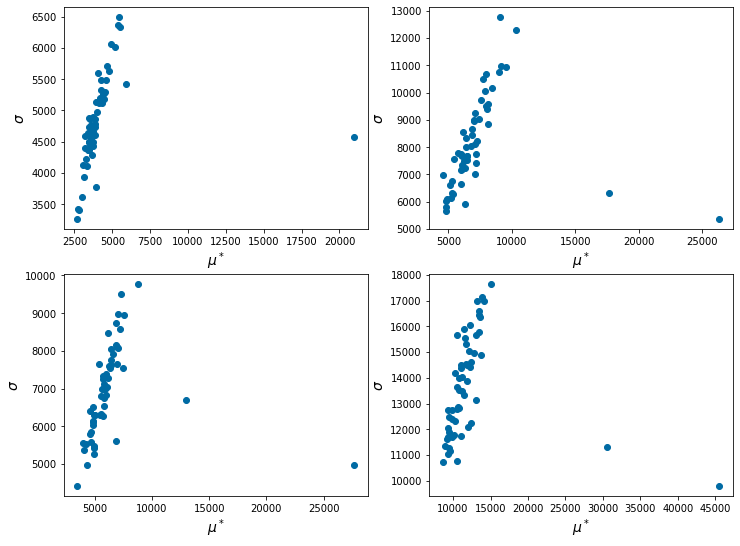

In [67]:
top = len(dfSi[(1,26)])

fig, ax = plt.subplots(2,2,figsize=(12,9))
for s in range(len(scenarios)):
    scen = scenarios[s]
    names  = list(dfSi[scen].sort_values(by="mu_star", ascending=False).iloc[:top]["names"])
    mustar = list(dfSi[scen].sort_values(by="mu_star", ascending=False).iloc[:top]["mu_star"])
    sigma  = list(dfSi[scen].sort_values(by="mu_star", ascending=False).iloc[:top]["sigma"])
    ax[int(s/2)][s%2].scatter(mustar,sigma)
    ax[int(s/2)][s%2].set_xlabel("$\\mu^*$", fontsize=14);
    ax[int(s/2)][s%2].set_ylabel("$\\sigma$", fontsize=14);